In [1]:
import pandas as pd
from IPython.display import SVG

# Metagenomics

## Steps of the analysis

* QC of raw reads with [fastqc](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/)
* Read trimming with [fastp](https://github.com/OpenGene/fastp)
    * Removes adapters, drops reads with average PHRED quality  below 20
    * Does QC of trimmed reads
* Mapping reads to reference with [minimap2](https://github.com/lh3/minimap2)
* Filter alignment files with samtools view
    * Removes reads that are not mapped in propper paris
    * Removes reads with a mapping PHRED score below 60 (in minimap2 this is equilivant to 30)
* Call variants with [freebayes](https://github.com/freebayes/freebayes)
    * Allele needs to be present 3 times
    * Minimum allele fraction is 0.05
    * Minimum 30 PHRED mapping quality (redundant because of filtering)
    * Minimum 20 PHRED base quality
* Annotate alleles with [SnpEFF](https://pcingola.github.io/SnpEff/snpeff/build_db/#step-2-option-2-building-a-database-from-genbank-files)
* Filter alleles with custom python script [vcf_exporter.py](https://github.com/sulheim/leakage/blob/eric/code/meta_sequencing/results/vcf_exporter.py)
    * All frequencies
        * Minimum allele frequency: 0.05
        * Minimum PHRED qual calculated by freebayes 30
        * Minimum allele count: 5
        * Minimum depth at allele site: 30
    * Fixed alleles:
        * Minimum allele frequency: 0.9
        * Minimum PHRED qual calculated by freebayes 30
        * Minimum depth at allele site: 30

## File- and directory strucutre

There was a disk quota issue so the processing was done on `/work/FAC/FBM/DMF/smitri/evomicrocomm/seq_snorre/data/meta_sequencing`.
`references_sequencing/` contains FASTA and annotation files, `meta_sequencing/` contains all files from the samples.  
The code is available in this repo under `../../code/meta_sequencing/` where mainly the Snakefile is important.  
`vcf_exporter.py` grabs the files from freebayes and filters the alleles. The output is a csv that I dump under the `../code/meta_sequencing/results` in different folders:
* `all_variants`:
    * All variants outputted by freebayes (note there is already some default filtering)
* `all_filtered_variants`:
    * All filtered variants according to `vcf_exporter.py` filter described above
* `fixed_filtered_variants`:
    * Fixed alleles filtered according to `vcf_exporter.py` described above
      
The `csv` contains following columns:  
`chrom,pos,qual,depth,freq,alt,alt_count,ref,type,len,eff,gene,product,linegroup,sample`
* `freq`: Allele frequency
* `alt`: Nucleotite,deletions,or insertion in allele
* `alt_count`: Number of reads with the observed allele
* `ref`: Nucleotide or sequence in reference
* `type`: Type of mutation
* `eff`: Effect if CDS on translated feature
* `linegroup`: Unique identifiers for each allele (also unique across samples)

## Some quality checks

We can look at the area of the knockout genes AceE and SucB to check if no strains were confused during the processing. Everything looks good!

### AceE (Position 119504-122167)

![meta_acee](../screenshots/meta_alignments_AceE.png)

### SucB (Position 756978-758195)

![meta_sucb](../screenshots/meta_alignments_SucB.png)

## Coverage
![coverage](../screenshots/fig1_coverage.png)

## Frequencies of alleles across samples (each dot is one allele)

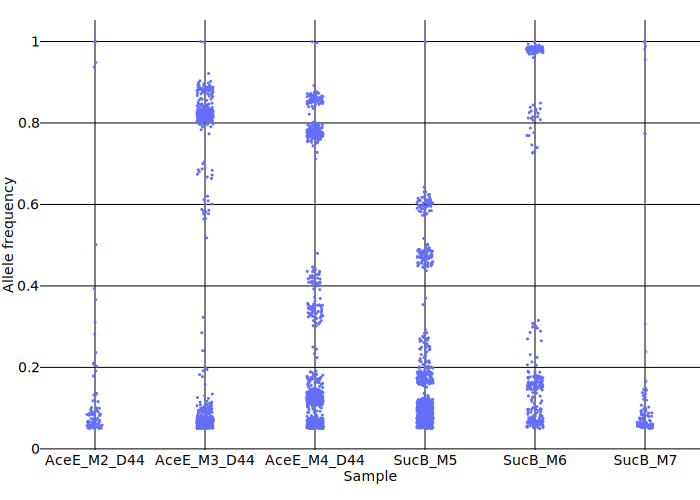

In [8]:
SVG(filename='../../code/meta_sequencing/plots/fig2_frequencies.svg')

## Fixed alleles (frequency >= 0.9) across samples

***ynfM* Putative arabinose efflux transporter fixed in all AceE samples**

Two not annotated SNPs across all samples for SucB


In [2]:
df = pd.read_csv('../../code/meta_sequencing/results/fixed_filtered_variants/all_samples.filtered.csv')[['pos','gene','product','sample']]
aceE = df[df['sample'] == 'AceE_M2_D44']
aceE


,pos,gene,product,sample
136,1436272,ldhA,"fermentative D-lactate dehydrogenase, NAD-depe...",AceE_M2_D44
137,1622605,NaN,NaN,AceE_M2_D44
138,1664690,ynfM,putative arabinose efflux transporter,AceE_M2_D44
139,2234994,galS,galactose- and fucose-inducible galactose regu...,AceE_M2_D44
140,2719426,NaN,NaN,AceE_M2_D44


In [3]:
df = pd.read_csv('../../code/meta_sequencing/results/fixed_filtered_variants/all_samples.filtered.csv')[['pos','gene','product','sample']]
SucB = df[df['sample'] == 'SucB_M5']
SucB

,pos,gene,product,sample
143,447145,NaN,NaN,SucB_M5
144,2719426,NaN,NaN,SucB_M5


## Alleles present across samples

In [4]:
aceE_samples = ['AceE_M2_D44','AceE_M3_D44','AceE_M4_D44']
sucB_samples = ['SucB_M5','SucB_M6','SucB_M7']
all_samples = aceE_samples + sucB_samples

def parallel_products(samples,min_count):
    dfs = [pd.read_csv('../../code/meta_sequencing/results/all_filtered_variants/' + sample + '.filtered.csv') for sample in samples]
    products = []
    for df in dfs:
        products += df['product'].to_list()
    product_dict = {key:0 for key in set(products)}
    
    for df in dfs:
        for product in product_dict.keys():
            if product in df['product'].to_list():
                product_dict[product] += 1
    
    for product,count in product_dict.items():
        if count >= min_count:
            print(product)

parallel_products(all_samples,4)

bacteriophage N4 receptor, inner membrane subunit
inner membrane putative ABC superfamily transporter permease
sensory histidine kinase in two-component regulatory system with NarP (NarL)
fermentative D-lactate dehydrogenase, NAD-dependent
FimA homolog
ribonuclease II
dsd operon activator; autorepressor
putative transcriptional regulator
DNA polymerase III epsilon subunit
isocitrate dehydrogenase kinase/phosphatase
adenylosuccinate lyase
putative outer membrane protein
N-succinyl-diaminopimelate deacylase
galactose- and fucose-inducible galactose regulon transcriptional isorepressor; mgl operon transcriptional repressor; autorepressor
aerobic respiration control sensor histidine protein kinase, cognate to two-component response regulators ArcA and RssB
cytochrome o ubiquinol oxidase subunit II
mgrR
hydrogenase 4, membrane subunit
uncharacterized protein
lipoprotein
putative DNA-binding transcriptional regulator
osmoregulated periplasmic glucan (OPG) biosynthesis periplasmic protein
uri

# Isolate sequencing

Same steps as for metagenomics. However, minimum allele frequency is set to 0.95.

## File- and directory structure

The data is on `/work/FAC/FBM/DMF/smitri/default/leakage/data/isolate_sequencing`. Code in `/work/FAC/FBM/DMF/smitri/default/leakage/code/isolate_sequncing`. I expotred the variants using the `vcf_exporter.py` in `../../code/isolate_sequencing/results/vcf_exporter.py`.  
The filtered variants with frequency >= 0.95 are in `../../code/isolate_sequencing/results/filtered_variants`. All variants are in `../../code/isolate_sequencing/results/all_variants`.
aceE_samples = ['AceE_M2_D44','AceE_M3_D44','AceE_M4_D44']
sucB_samples = ['SucB_M5','SucB_M6','SucB_M7']
all_samples = aceE_samples + sucB_samples
dfs = [pd.read_csv('../../code/meta_sequencing/results/all_filtered_variants/' + sample + '.filtered.csv') for sample in samples]

## SNPs

Bad news, *ynfM* is in the ancestor as well.

In [5]:
aceE_samples = ['AceE_anc','AceE_M2_iso','AceE_M3_iso','AceE_M4_iso']
sucB_samples = ['SucB_anc','SucB_M5_iso','SucB_M6_iso','SucB_M7_iso']
all_samples = aceE_samples + sucB_samples
dfs = [pd.read_csv('../../code/isolate_sequncing/results/filtered_variants/' + sample + '.filtered.csv')[['pos','gene','product','sample']] for sample in aceE_samples]
dfs[3]

,pos,gene,product,sample
0,1455,thrA,Bifunctional aspartokinase/homoserine dehydrog...,AceE_M4_iso
1,2297,thrA,Bifunctional aspartokinase/homoserine dehydrog...,AceE_M4_iso
2,9100,talB,transaldolase B,AceE_M4_iso
3,9125,talB,transaldolase B,AceE_M4_iso
4,22360,NaN,NaN,AceE_M4_iso
...,...,...,...,...
265,4532543,NaN,NaN,AceE_M4_iso
266,4538883,fimH,minor component of type 1 fimbriae,AceE_M4_iso
267,4559788,NaN,NaN,AceE_M4_iso
268,4579955,yjiY,putative transporter,AceE_M4_iso
